In [1]:
print("start")

start


In [2]:
# importing tensorflow
import sys
import codecs
import tensorflow as tf


!pip install tensorflow


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm

from sklearn.metrics import jaccard_score


In [4]:
# Test if the  modules are accessible
try:
    print("All imports successful!")

    # Create a dummy input layer
    inputs = Input((128, 128, 3))  # Example input shape: 128x128 RGB image

    # Add a convolutional layer
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    # Add a max-pooling layer
    pool1 = MaxPooling2D((2, 2))(conv1)

    # Add a Conv2DTranspose layer
    upsample = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(pool1)

    # Add a dropout layer
    dropout = Dropout(0.5)(upsample)

    # Add a concatenate layer
    concat = concatenate([conv1, dropout])

    # Define a simple model
    model = Model(inputs=[inputs], outputs=[concat])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

    # Print the model summary
    print("Model created successfully!")
    model.summary()

except Exception as e:
    print("An error occurred:")
    print(e)


All imports successful!
Model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 16)   │          2,320 │ max_pooling2d[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 32)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,768 (10.81 KB)

 Trainable params: 2,768 (10.81 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import os

# Check the extracted files
print("Extracted files:", os.listdir("/kaggle/input/plantseg1"))


Extracted files: ['plantseg']


In [6]:
# Paths to training and testing datasets
train_images_path = "/kaggle/input/plantseg1/plantseg/images/train"  # Training images
test_images_path = "/kaggle/input/plantseg1/plantseg/images/test"    # Testing images

# Paths to training and testing masks
train_masks_path = "/kaggle/input/plantseg1/plantseg/annotations/train"  # Training masks
test_masks_path = "/kaggle/input/plantseg1/plantseg/annotations/test"    # Testing masks


In [7]:
# Image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3  # Number of channels in the input images (RGB)

# copying 
image_source_dir = train_images_path
mask_source_dir = train_masks_path

# UPDATED !!!
test_source_dir = test_images_path 
test_mask_dir = test_masks_path

# Preprocess the dataset
image_files = os.listdir(image_source_dir)  # List all image files
mask_files = os.listdir(mask_source_dir)  # List all mask files

# UPDATED !!!
test_image = os.listdir(test_source_dir) # List all test image files 
test_mask = os.listdir(test_mask_dir)



In [8]:
# Split dataset into training and validation sets
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)
num_train_samples = len(train_images)
num_val_samples = len(val_images)
num_test_samples = len(test_image)

# Prepare arrays for storing training and validation data
X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)  # Input images for training
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)  # Corresponding masks for training

X_val = np.zeros((num_val_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)  # Input images for validation
Y_val = np.zeros((num_val_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)  # Corresponding masks for validation

X_test = np.zeros((num_test_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)  # Input images for testing 
Y_test = np.zeros((num_test_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)  # Corresponding masks for testing 

In [9]:
print("Processing training data")
# Resize and load training data
for i, image_file in tqdm(enumerate(train_images), total=num_train_samples):
    img_path = os.path.join(image_source_dir, image_file)  # Path to the input image
    mask_path = os.path.join(mask_source_dir, image_file.replace('.jpg', '.png'))  # Path to the corresponding mask

    img = Image.open(img_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
    img = np.array(img)  # Convert to a NumPy array
    mask = np.array(Image.open(mask_path).convert('L'))  # Read and convert the mask to grayscale

    X_train[i] = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize the image
    Y_train[i] = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True) > 0  # Resize and binarize the mask






Processing training data


100%|██████████| 7330/7330 [37:30<00:00,  3.26it/s]  


In [10]:
print("Processing validation data")
# Resize and load validation data
for i, image_file in tqdm(enumerate(val_images), total=num_val_samples):
    img_path = os.path.join(image_source_dir, image_file)  # Path to the input image
    mask_path = os.path.join(mask_source_dir, image_file.replace('.jpg', '.png'))  # Path to the corresponding mask

    img = Image.open(img_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
    img = np.array(img)  # Convert to a NumPy array
    mask = np.array(Image.open(mask_path).convert('L'))  # Read and convert the mask to grayscale

    X_val[i] = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize the image
    Y_val[i] = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True) > 0  # Resize and binarize the mask

Processing validation data


100%|██████████| 1833/1833 [08:17<00:00,  3.69it/s]


In [11]:
# UPDATED !!! 
print("Processing test data")
# Resize and load validation data
for i, image_file in tqdm(enumerate(test_image), total=num_test_samples):
    img_path = os.path.join(test_source_dir, image_file)  # Path to the input image
    mask_path = os.path.join(test_mask_dir, image_file.replace('.jpg', '.png'))  # Path to the corresponding mask

    img = Image.open(img_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
    img = np.array(img)  # Convert to a NumPy array
    mask = np.array(Image.open(mask_path).convert('L'))  # Read and convert the mask to grayscale

    X_test[i] = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize the image
    Y_test[i] = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True) > 0  # Resize and binarize the mask




Processing test data


100%|██████████| 2295/2295 [11:48<00:00,  3.24it/s] 


In [12]:
# Define the U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """
    Builds the U-Net model for segmentation tasks.

    Args:
        input_size (tuple): Dimensions of the input images.

    Returns:
        model (tensorflow.keras.Model): Compiled U-Net model.
    """
    inputs = Input(input_size)
    s = inputs

    # Contracting Path (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(s)  # First convolutional layer
    c1 = Dropout(0.1)(c1)  # Add dropout for regularization
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)  # Second convolutional layer
    p1 = MaxPooling2D((2, 2))(c1)  # Downsample using max pooling

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)  # Convolutional layer with 128 filters
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)  # Convolutional layer with 256 filters
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)  # Convolutional layer with 512 filters
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)  # Bottleneck layer
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)  # Upsample and reduce filters
    u6 = concatenate([u6, c4])  # Concatenate with the corresponding encoder layer
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Final output layer with a sigmoid activation

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])  # Compile the model

    return model



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 8, 512)      │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6766 - loss: 1.5491 - mean_io_u_1: 0.2875   
Epoch 1: val_loss improved from inf to 0.64513, saving model to plantseg_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.6769 - loss: 1.5432 - mean_io_u_1: 0.2871 - val_accuracy: 0.7234 - val_loss: 0.6451 - val_mean_io_u_1: 0.3344
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7200 - loss: 0.6199 - mean_io_u_1: 0.2864
Epoch 2: val_loss improved from 0.64513 to 0.56890, saving model to plantseg_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 99s 858ms/step - accuracy: 0.7201 - loss: 0.6196 - mean_io_u_1: 0.2861 - val_accuracy: 0.7270 - val_loss: 0.5689 - val_mean_io_u_1: 0.3344
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.7363 - loss: 0.5516 - mean_io_u_1: 0.2883
Epoch 3: val_loss improved from 0.56890 to 0.52443, saving model to plantseg_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 99s 862ms/step - accuracy: 0.7364 - loss: 0.551

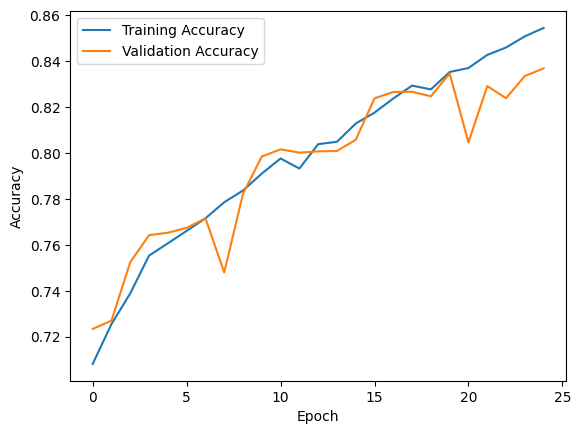

58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - accuracy: 0.8351 - loss: 0.3604 - mean_io_u_1: 0.3575
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 0.8327 - loss: 0.3650 - mean_io_u_1: 0.3529


[0.3585837185382843, 0.8369664549827576, 0.31220442056655884]

In [13]:
# Instantiate and train the model
model = unet_model()
model.summary()

# Callbacks for saving the model and early stopping
checkpointer = ModelCheckpoint('plantseg_unet.keras', verbose=1, save_best_only=True)  # Save the best model
  # Save the best model
# early_stopper = EarlyStopping(patience=3, monitor='val_loss')  # Stop training if validation loss doesn't improve

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    #batch_size=16,
    batch_size=64,
    #batch_size=64,
    #epoch=25,
    epochs=25,
    # callbacks=[checkpointer, early_stopper]
    callbacks = [checkpointer],
)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation data
model.evaluate(X_val, Y_val, verbose=1)  # Print evaluation metrics

# Evaluate the model on validation data
model.evaluate(X_test, Y_test, verbose=1)  # Print evaluation metrics

In [14]:
# Using batch size = 16 with epoch = 25, accuracy = 85.57% 
# Using batch size = 64 with epoch = 25, accuracy = 82.01%
##############################################################
# Using batch size = 64 with epoch = 5, accuracy = 77.5% 
# Using batch size = 32 with epoch = 5, accuracy = 75.56%
# Using batch size = 16 with epoch = 5, accuracy = 74.0% 

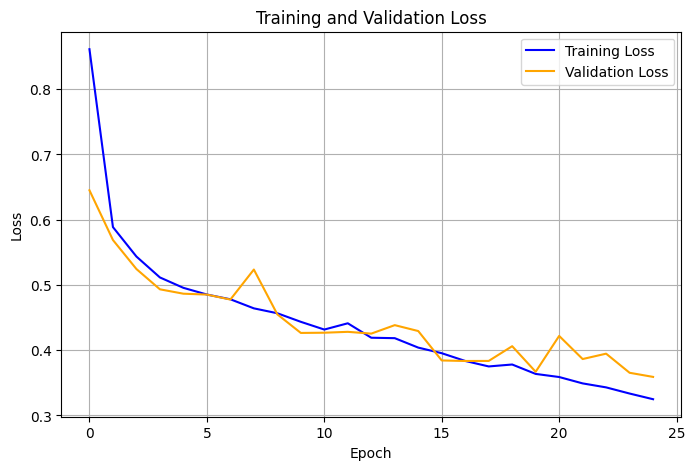

In [15]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:


# # Assuming the ground truth and predicted masks are numpy arrays
# # You should have binary masks for each class or multi-class masks
# def compute_metrics(pred_mask, true_mask, num_classes):
#     # Ensure the masks are flattened (1D)
#     pred_mask = pred_mask.flatten()
#     true_mask = true_mask.flatten()

#     # Pixel Accuracy
#     pixel_accuracy = np.sum(pred_mask == true_mask) / len(true_mask)

#     # IoU (Intersection over Union)
#     iou_list = []
#     for i in range(num_classes):
#         # Calculate IoU for each class
#         pred_class = (pred_mask == i)
#         true_class = (true_mask == i)

#         intersection = np.sum(pred_class & true_class)
#         union = np.sum(pred_class | true_class)

#         iou = intersection / (union + 1e-6)  # Add a small epsilon to prevent division by zero
#         iou_list.append(iou)

#     mean_iou = np.mean(iou_list)

#     # Dice Coefficient
#     dice_list = []
#     for i in range(num_classes):
#         pred_class = (pred_mask == i)
#         true_class = (true_mask == i)

#         intersection = np.sum(pred_class & true_class)
#         dice = (2 * intersection) / (np.sum(pred_class) + np.sum(true_class) + 1e-6)
#         dice_list.append(dice)

#     mean_dice = np.mean(dice_list)

#     return pixel_accuracy, mean_iou, mean_dice

# # Example usage with predicted and true masks
# num_classes = 1  # Example: for binary segmentation, num_classes would be 2 (background, foreground)

# # Example data (replace with actual masks)
# pred_mask = np.array([[0, 1, 0], [1, 1, 0], [0, 0, 1]])
# true_mask = np.array([[0, 1, 0], [0, 1, 0], [0, 0, 1]])

# # Call the function to compute the metrics
# pixel_accuracy, mean_iou, mean_dice = compute_metrics(pred_mask, true_mask, num_classes)

# print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
# print(f"Mean IoU: {mean_iou:.4f}")
# print(f"Mean Dice Coefficient: {mean_dice:.4f}")
# Evaluate the model on validation data
model.evaluate(X_test, Y_test, verbose=1)


72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8327 - loss: 0.3650 - mean_io_u_1: 0.3529


[0.3585837185382843, 0.8369664549827576, 0.31220442056655884]

In [18]:
# Generate predicted masks from the model
pred_mask = model.predict(X_test)
pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold for binary mask


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step


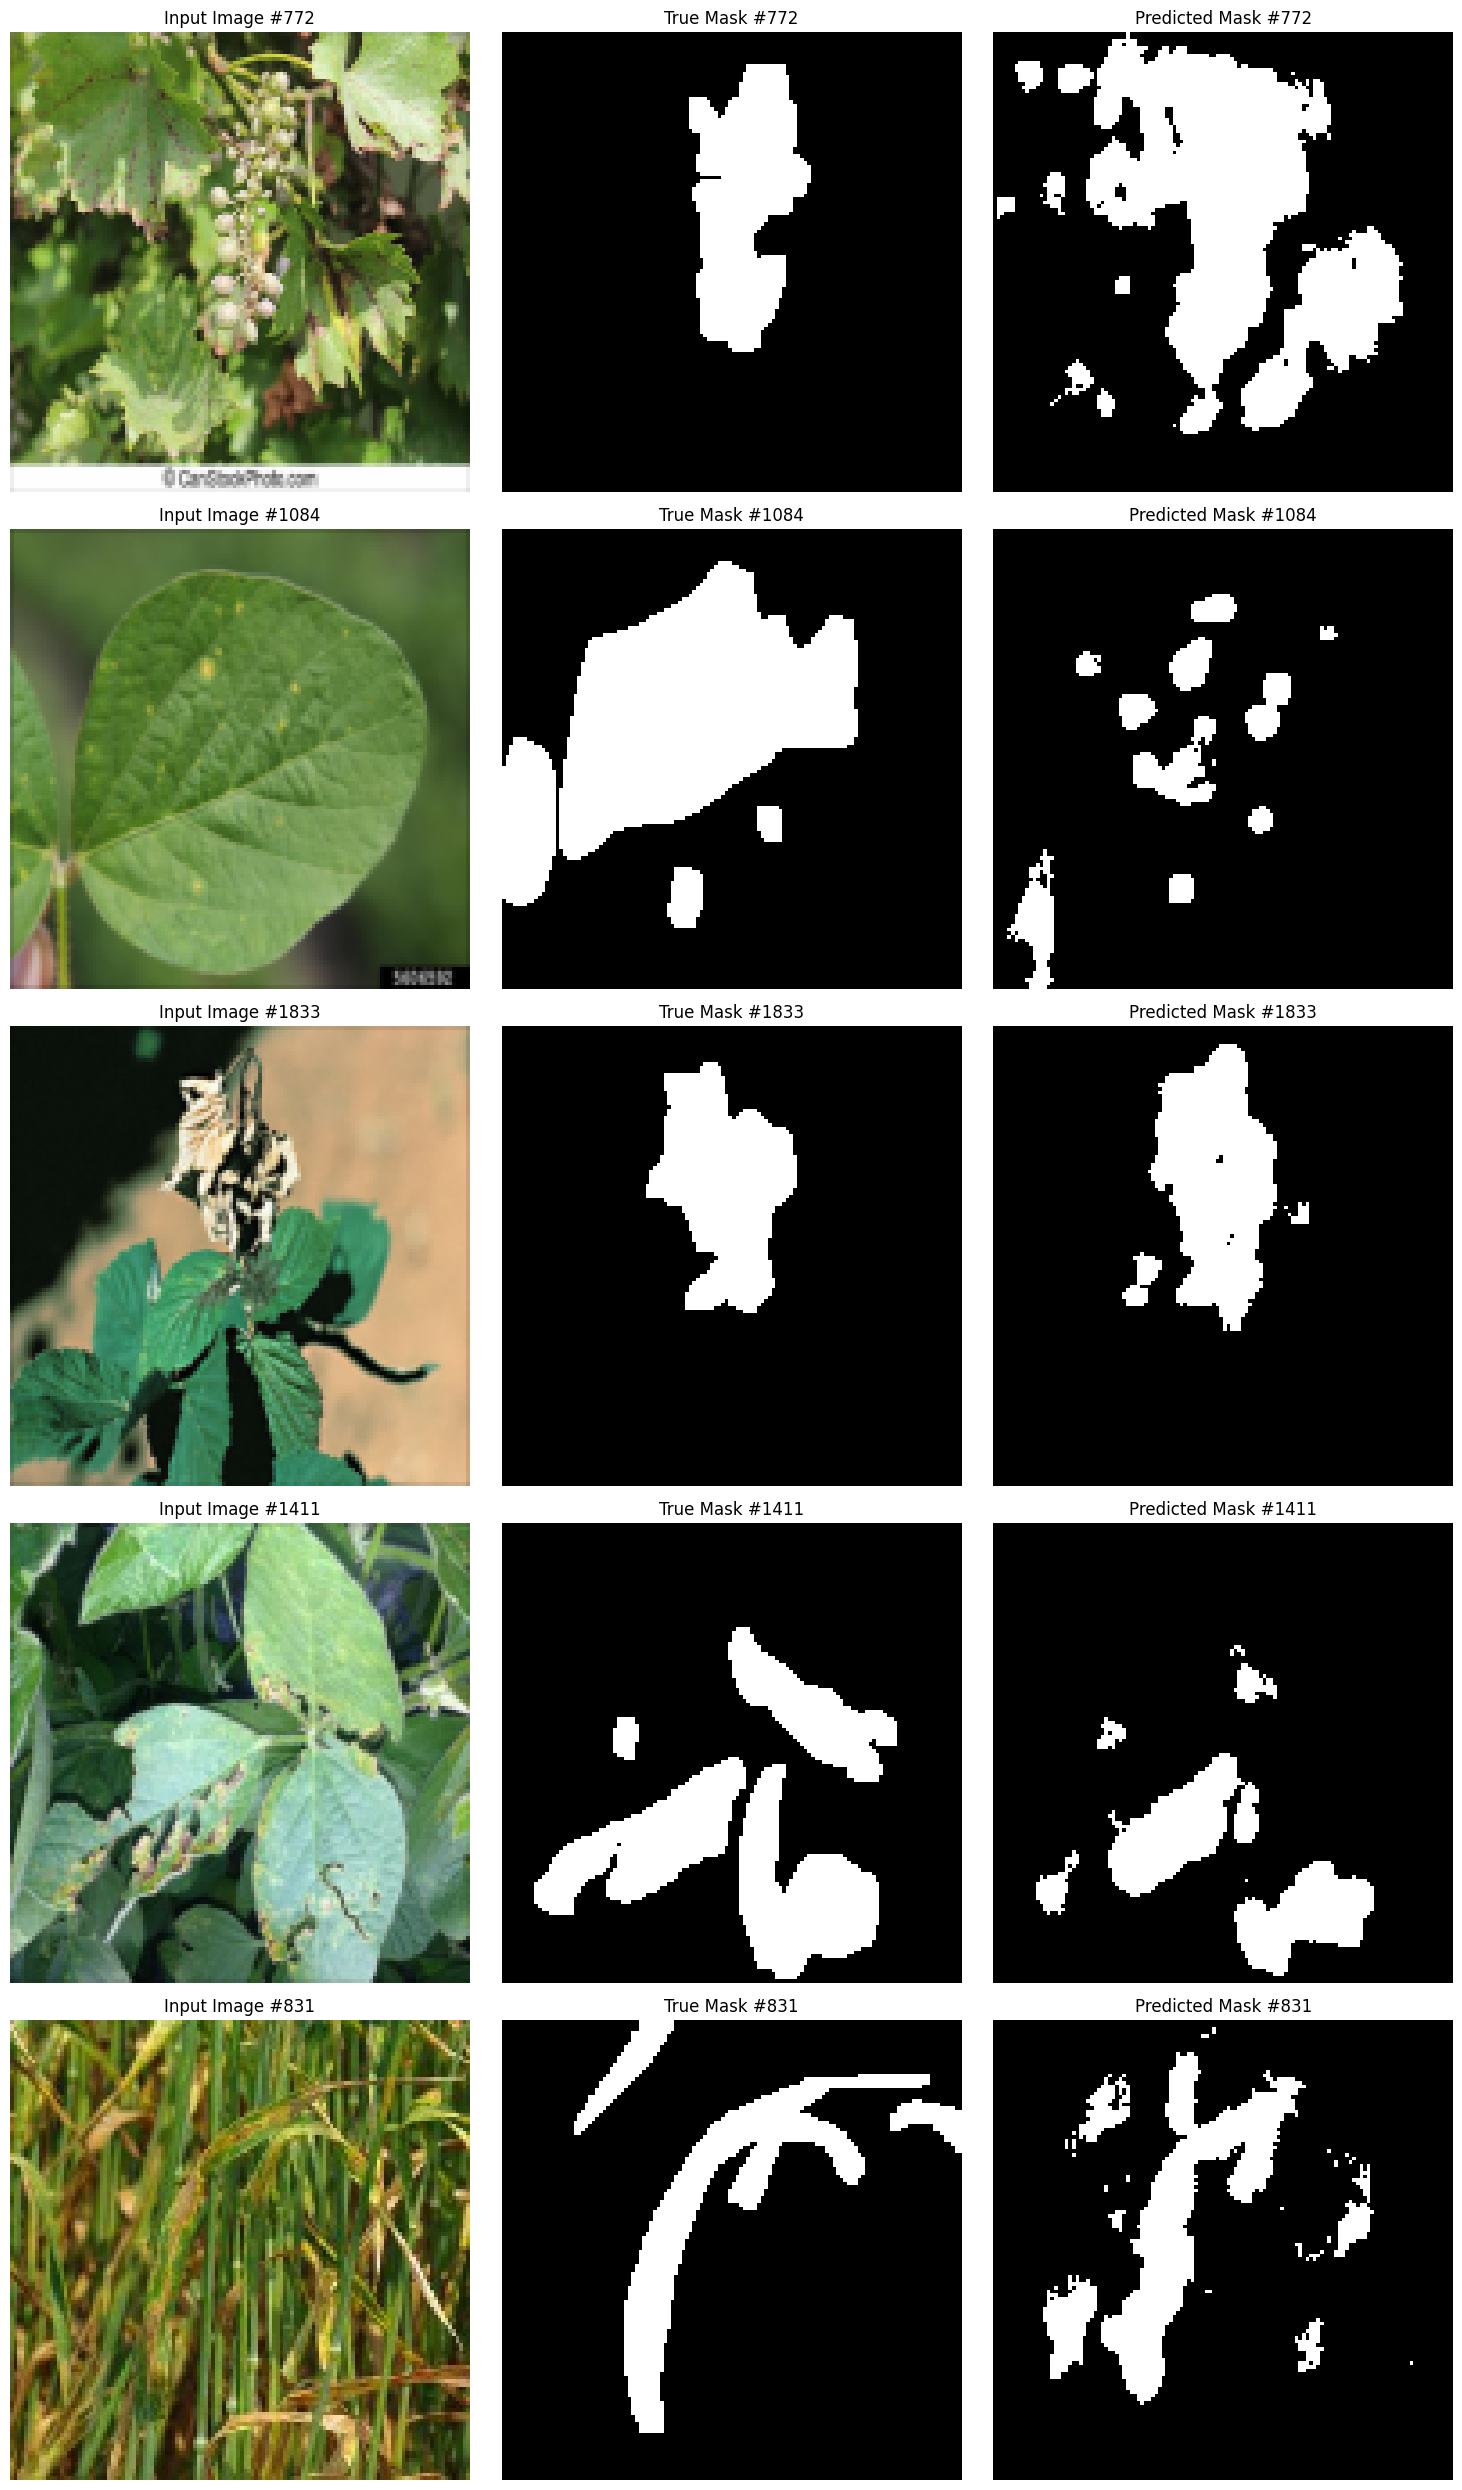

In [19]:
import matplotlib.pyplot as plt
import random

def visualize_results(X_test, Y_test, pred_mask, sample_count=5):
    """
    Visualize the input images, true masks, and predicted masks.

    Args:
        X_test (numpy array): Test images.
        Y_test (numpy array): Ground truth masks.
        pred_mask (numpy array): Predicted masks.
        sample_count (int): Number of samples to visualize.
    """
    # Ensure masks are squeezed if necessary
    pred_mask = np.squeeze(pred_mask)
    Y_test = np.squeeze(Y_test)

    # Randomly pick `sample_count` indices from the test set
    indices = random.sample(range(len(X_test)), sample_count)

    plt.figure(figsize=(15, sample_count * 5))

    for i, idx in enumerate(indices):
        # Test image
        plt.subplot(sample_count, 3, i * 3 + 1)
        plt.imshow(X_test[idx])
        plt.title(f"Input Image #{idx}")
        plt.axis('off')

        # True mask
        plt.subplot(sample_count, 3, i * 3 + 2)
        plt.imshow(Y_test[idx], cmap='gray')
        plt.title(f"True Mask #{idx}")
        plt.axis('off')

        # Predicted mask
        plt.subplot(sample_count, 3, i * 3 + 3)
        plt.imshow(pred_mask[idx], cmap='gray')
        plt.title(f"Predicted Mask #{idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 random samples
visualize_results(X_test, Y_test, pred_mask, sample_count=5)


In [20]:
# Assuming the ground truth and predicted masks are numpy arrays
# You should have binary masks for each class or multi-class masks
def compute_metrics(pred_mask, true_mask, num_classes):
    # Ensure the masks are flattened (1D)
    pred_mask = pred_mask.flatten()
    true_mask = true_mask.flatten()

    # Pixel Accuracy
    pixel_accuracy = np.sum(pred_mask == true_mask) / len(true_mask)

    # IoU (Intersection over Union)
    iou_list = []
    for i in range(num_classes):
        # Calculate IoU for each class
        pred_class = (pred_mask == i)
        true_class = (true_mask == i)

        intersection = np.sum(pred_class & true_class)
        union = np.sum(pred_class | true_class)

        iou = intersection / (union + 1e-6)  # Add a small epsilon to prevent division by zero
        iou_list.append(iou)

    mean_iou = np.mean(iou_list)

    # Dice Coefficient
    dice_list = []
    for i in range(num_classes):
        pred_class = (pred_mask == i)
        true_class = (true_mask == i)

        intersection = np.sum(pred_class & true_class)
        dice = (2 * intersection) / (np.sum(pred_class) + np.sum(true_class) + 1e-6)
        dice_list.append(dice)

    mean_dice = np.mean(dice_list)

    return pixel_accuracy, mean_iou, mean_dice

# Example usage with predicted and true masks
num_classes = 1  # Example: for binary segmentation, num_classes would be 2 (background, foreground)

# Generate predicted masks for the test set
pred_mask = model.predict(X_test)  # Predict segmentation for the test images
pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert probabilities to binary mask (threshold = 0.5)

# Use true masks from the test set
true_mask = np.squeeze(Y_test)  # Remove unnecessary dimensions from ground truth masks

# Compute evaluation metrics
pixel_accuracy, mean_iou, mean_dice = compute_metrics(pred_mask, true_mask, num_classes=1)

print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step
Pixel Accuracy: 0.8370
Mean IoU: 0.8021
Mean Dice Coefficient: 0.8902


In [21]:
# Paths to training and testing datasets
lab_test_images_path = "/kaggle/input/labtest/Demo images"  # Training images
print("s")


s


In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Model

# Define paths
lab_test_images_path = "/kaggle/input/labtest/Demo Images"
output_folder = "/kaggle/working/predicted_masks"
os.makedirs(output_folder, exist_ok=True)


IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3

# Preprocess test images
def preprocess_images(folder_path, img_height, img_width):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames


test_images, test_filenames = preprocess_images(lab_test_images_path, IMG_HEIGHT, IMG_WIDTH)


model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) 



predicted_masks = model.predict(test_images)


threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Save the predicted masks
for i, mask in enumerate(predicted_masks):
    mask_resized = cv2.resize(mask.squeeze(), (IMG_WIDTH, IMG_HEIGHT))  
    output_path = os.path.join(output_folder, f"mask_{test_filenames[i]}")
    cv2.imwrite(output_path, mask_resized * 255)  


NameError: name 'img' is not defined

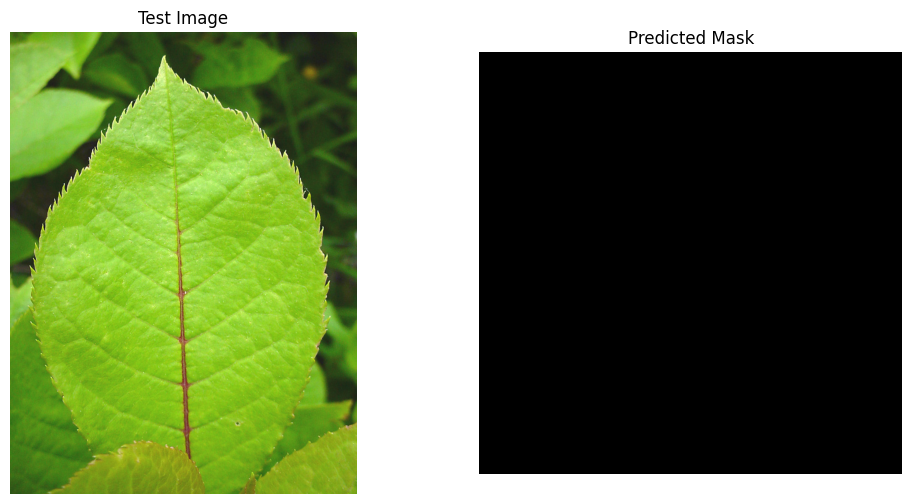

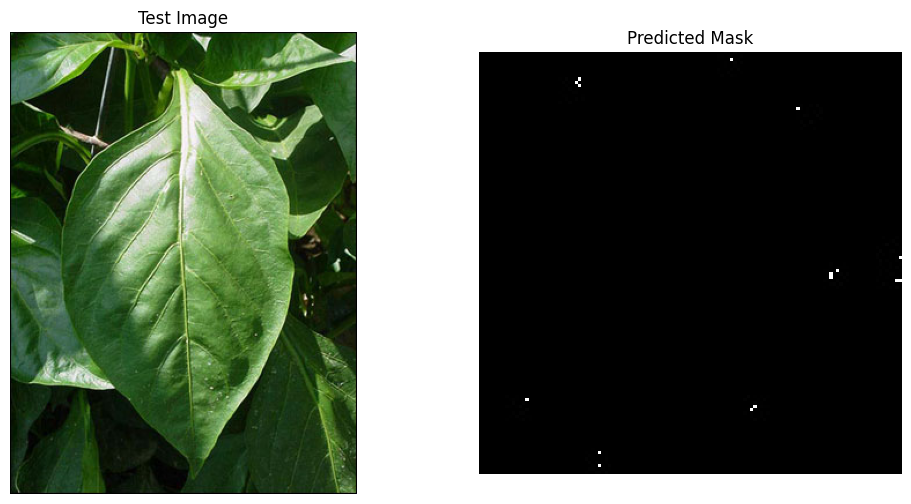

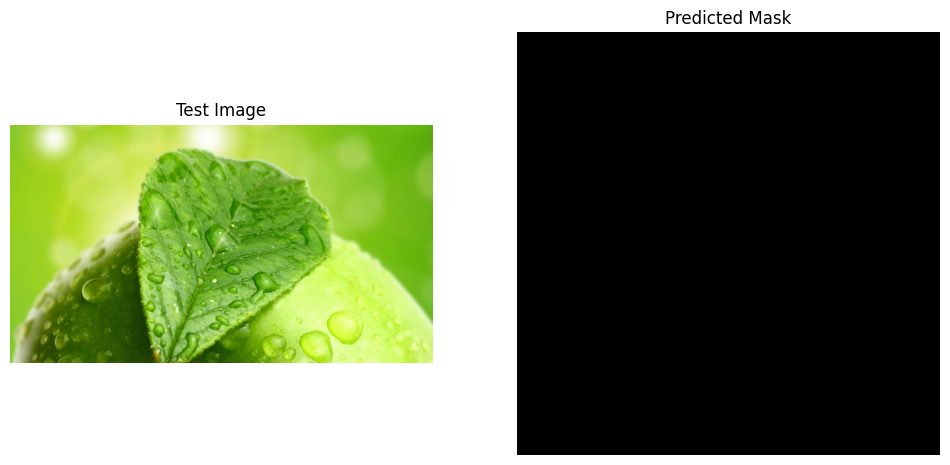

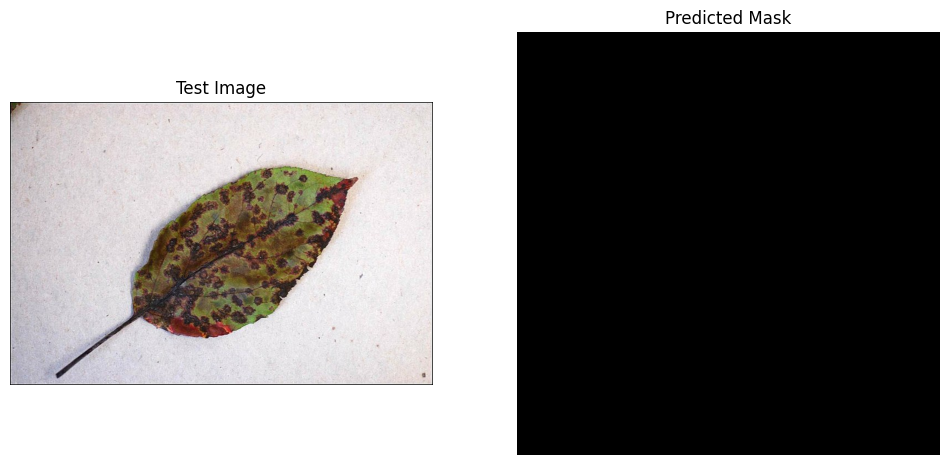

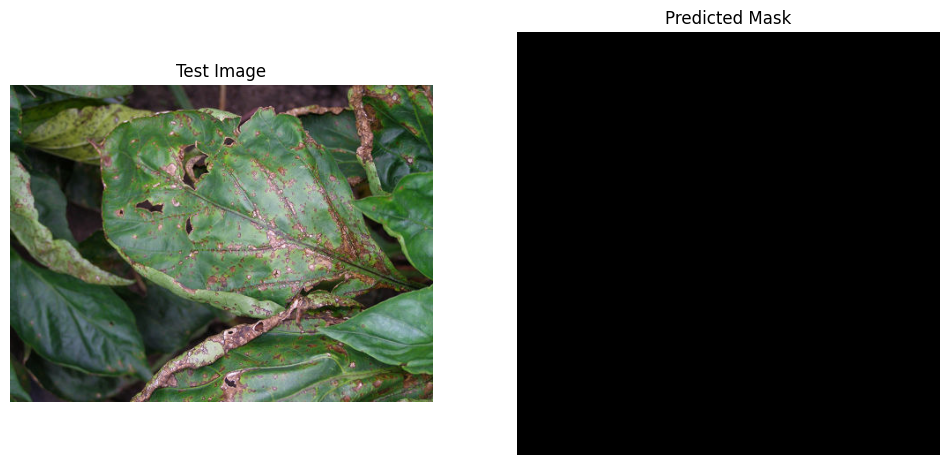

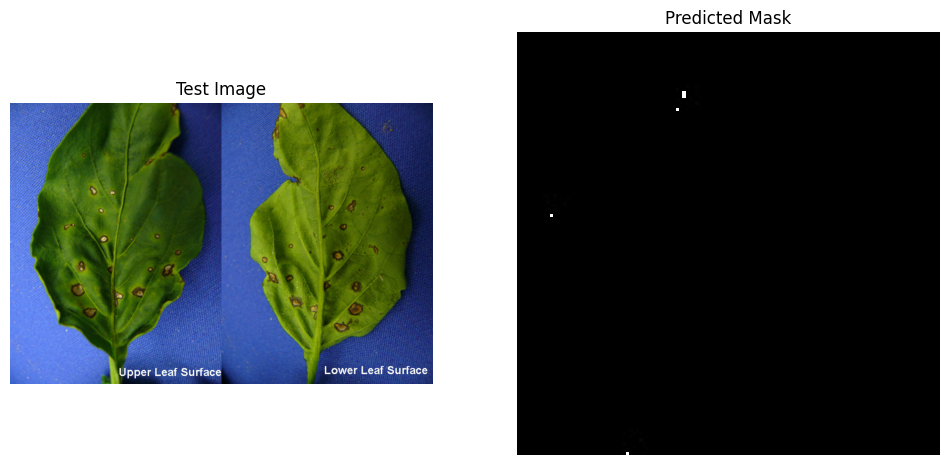

In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt


lab_test_images_path = "/kaggle/input/labtest/Demo Images"
output_folder = "/kaggle/working/predicted_masks"

test_images = sorted([f for f in os.listdir(lab_test_images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
output_images = sorted([f for f in os.listdir(output_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])


if len(test_images) != len(output_images):
    print("Warning: The number of test images and output images do not match.")


for test_image, output_image in zip(test_images, output_images):
    test_image_path = os.path.join(lab_test_images_path, test_image)
    output_image_path = os.path.join(output_folder, output_image)


    img1 = Image.open(test_image_path)
    img2 = Image.open(output_image_path)

  
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Test Image")
    plt.axis("off")
    
    # Show the output image
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()
